## Importing the libraries

In [2]:
# Cell 1: Import libraries
import psycopg2
import pandas as pd
import numpy as np
from datetime import datetime
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

print("✅ Libraries imported")
print(f"Python: {sys.version}")

✅ Libraries imported
Python: 3.10.12 (main, Aug 15 2025, 14:32:43) [GCC 11.4.0]


## Connecting to the database

In [4]:
# Cell 2: Check what's already in the database from your terminal work
print("🔍 Checking existing database state...")
print("=" * 50)

# Connect to the database you created
conn = psycopg2.connect(
    dbname="bank_reviews",
    user="bank_user",
    password="bank123",
    host="localhost",
    port=5432
)

cur = conn.cursor()

# 1. List all tables (like \dt in terminal)
print("\n1. Tables in database:")
print("-" * 30)
cur.execute("""
    SELECT table_name 
    FROM information_schema.tables 
    WHERE table_schema = 'public'
    ORDER BY table_name;
""")

tables = cur.fetchall()
if tables:
    for table in tables:
        print(f"   ✓ {table[0]}")
else:
    print("   No tables found")

# 2. Check banks table (you created this in terminal)
print("\n2. Banks table (created in terminal):")
print("-" * 30)
cur.execute("SELECT COUNT(*) FROM banks;")
bank_count = cur.fetchone()[0]
print(f"   Total banks: {bank_count}")

if bank_count > 0:
    cur.execute("SELECT * FROM banks ORDER BY bank_id;")
    print("   Bank details:")
    for bank in cur.fetchall():
        bank_id, bank_name, app_name = bank
        print(f"     ID: {bank_id}, Name: {bank_name}, App: {app_name}")

# 3. Check reviews table (empty or has data)
print("\n3. Reviews table:")
print("-" * 30)
cur.execute("SELECT COUNT(*) FROM reviews;")
review_count = cur.fetchone()[0]
print(f"   Total reviews: {review_count}")

if review_count > 0:
    cur.execute("""
        SELECT b.bank_name, COUNT(r.review_id) as review_count
        FROM banks b
        LEFT JOIN reviews r ON b.bank_id = r.bank_id
        GROUP BY b.bank_name
        ORDER BY review_count DESC;
    """)
    print("   Reviews per bank:")
    for bank_name, count in cur.fetchall():
        print(f"     {bank_name}: {count} reviews")

# 4. Check table structure (like \d in terminal)
print("\n4. Table structure:")
print("-" * 30)
cur.execute("""
    SELECT column_name, data_type 
    FROM information_schema.columns 
    WHERE table_name = 'reviews'
    ORDER BY ordinal_position;
""")

columns = cur.fetchall()
print("   Reviews table columns:")
for col_name, data_type in columns:
    print(f"     {col_name}: {data_type}")

cur.close()
conn.close()

print("\n" + "=" * 50)
print("✅ Database check complete!")
print(f"   Found: {len(tables)} tables, {bank_count} banks, {review_count} reviews")
print("=" * 50)

🔍 Checking existing database state...

1. Tables in database:
------------------------------
   ✓ banks
   ✓ reviews

2. Banks table (created in terminal):
------------------------------
   Total banks: 3
   Bank details:
     ID: 1, Name: Commercial Bank of Ethiopia, App: Commercial Bank of Ethiopia Mobile
     ID: 2, Name: Bank of Abyssinia, App: Bank of Abyssinia Mobile Banking
     ID: 3, Name: Dashen Bank, App: Dashen Bank Mobile Banking

3. Reviews table:
------------------------------
   Total reviews: 0

4. Table structure:
------------------------------
   Reviews table columns:
     review_id: integer
     bank_id: integer
     review_text: text
     rating: integer
     review_date: date
     sentiment_label: character varying
     sentiment_score: numeric
     source: character varying

✅ Database check complete!
   Found: 2 tables, 3 banks, 0 reviews


## Loading the data

In [6]:
# Cell 3: Load your processed reviews_processed.csv
print("📂 Loading processed reviews CSV...")
print("=" * 50)

import pandas as pd
from pathlib import Path

# Path to your processed data
csv_path = Path("../data/processed/reviews_processed.csv")

# Check if file exists
if csv_path.exists():
    print(f"✅ Found CSV file: {csv_path}")
    
    # Load the CSV
    df = pd.read_csv(csv_path)
    
    # Basic info about your data
    print(f"\n📊 CSV Data Overview:")
    print(f"   Total rows: {len(df):,}")
    print(f"   Total columns: {len(df.columns)}")
    
    # Show column names (important for mapping)
    print(f"\n📋 Column names:")
    for i, col in enumerate(df.columns, 1):
        print(f"   {i:2}. {col}")
    
    # Show data types
    print(f"\n🔧 Data types:")
    for col in df.columns:
        dtype = df[col].dtype
        non_null = df[col].notna().sum()
        print(f"   {col:<20} {str(dtype):<15} ({non_null} non-null)")
    
    # Show sample of the data
    print(f"\n👀 Sample data (first 3 rows):")
    # Select key columns to display
    key_columns = ['review_text', 'rating', 'review_date', 'bank_name', 'bank_code', 'source']
    available_cols = [col for col in key_columns if col in df.columns]
    
    if available_cols:
        sample_df = df[available_cols].head(3).copy()
        # Truncate long text for display
        if 'review_text' in sample_df.columns:
            sample_df['review_text'] = sample_df['review_text'].apply(
                lambda x: str(x)[:50] + "..." if len(str(x)) > 50 else str(x)
            )
        display(sample_df)
    else:
        print(df.head(3))
    
    # Statistics about your data
    print(f"\n📈 Key Statistics:")
    
    # Rating statistics
    if 'rating' in df.columns:
        print(f"\n   Rating distribution:")
        rating_counts = df['rating'].value_counts().sort_index()
        for rating, count in rating_counts.items():
            stars = "⭐" * int(rating)
            percentage = (count / len(df)) * 100
            print(f"     {stars} ({rating} stars): {count:>5} reviews ({percentage:.1f}%)")
    
    # Bank statistics
    if 'bank_name' in df.columns:
        print(f"\n   Bank distribution:")
        bank_counts = df['bank_name'].value_counts()
        for bank, count in bank_counts.items():
            percentage = (count / len(df)) * 100
            print(f"     {bank:<35}: {count:>5} reviews ({percentage:.1f}%)")
    
    # Date statistics
    if 'review_date' in df.columns:
        print(f"\n   Date range:")
        try:
            # Try to parse dates
            df['review_date_parsed'] = pd.to_datetime(df['review_date'], errors='coerce')
            valid_dates = df['review_date_parsed'].dropna()
            if len(valid_dates) > 0:
                print(f"     From: {valid_dates.min().date()}")
                print(f"     To:   {valid_dates.max().date()}")
                print(f"     Span: {(valid_dates.max() - valid_dates.min()).days} days")
        except:
            print(f"     Could not parse dates")
    
    # Text length statistics
    if 'review_text' in df.columns:
        print(f"\n   Review text length:")
        text_lengths = df['review_text'].astype(str).apply(len)
        print(f"     Average length: {text_lengths.mean():.0f} characters")
        print(f"     Min length: {text_lengths.min():.0f} characters")
        print(f"     Max length: {text_lengths.max():.0f} characters")
        
        # Check for empty/short reviews
        short_reviews = (text_lengths < 3).sum()
        if short_reviews > 0:
            print(f"     ⚠️  {short_reviews} reviews have less than 3 characters")
    
    print(f"\n" + "=" * 50)
    print(f"✅ CSV loaded successfully!")
    print(f"   Ready for database insertion in next cell")
    print("=" * 50)
    
else:
    print(f"❌ CSV file not found: {csv_path}")
    print("\nPlease check:")
    print(f"  1. File exists: ls -la {csv_path}")
    print(f"  2. Current directory: {Path.cwd()}")
    print(f"  3. Try: data/processed/reviews_processed.csv")

📂 Loading processed reviews CSV...
✅ Found CSV file: ../data/processed/reviews_processed.csv

📊 CSV Data Overview:
   Total rows: 1,350
   Total columns: 12

📋 Column names:
    1. review_id
    2. review_text
    3. rating
    4. review_date
    5. bank_code
    6. bank_name
    7. source
    8. user_name
    9. thumbs_up
   10. text_length
   11. review_year
   12. review_month

🔧 Data types:
   review_id            object          (1350 non-null)
   review_text          object          (1350 non-null)
   rating               int64           (1350 non-null)
   review_date          object          (1350 non-null)
   bank_code            object          (1350 non-null)
   bank_name            object          (1350 non-null)
   source               object          (1350 non-null)
   user_name            object          (1350 non-null)
   thumbs_up            int64           (1350 non-null)
   text_length          int64           (1350 non-null)
   review_year          int64           (1

,review_text,rating,review_date,bank_name,bank_code,source
0,Very Good,5,2025-11-28,Bank of Abyssinia,BOA,Google Play
1,goof,5,2025-11-28,Bank of Abyssinia,BOA,Google Play
2,good!,5,2025-11-28,Bank of Abyssinia,BOA,Google Play



📈 Key Statistics:

   Rating distribution:
     ⭐ (1 stars):   300 reviews (22.2%)
     ⭐⭐ (2 stars):    49 reviews (3.6%)
     ⭐⭐⭐ (3 stars):    73 reviews (5.4%)
     ⭐⭐⭐⭐ (4 stars):    99 reviews (7.3%)
     ⭐⭐⭐⭐⭐ (5 stars):   829 reviews (61.4%)

   Bank distribution:
     Bank of Abyssinia                  :   450 reviews (33.3%)
     Commercial Bank of Ethiopia        :   450 reviews (33.3%)
     Dashen Bank                        :   450 reviews (33.3%)

   Date range:
     From: 2024-08-28
     To:   2025-11-28
     Span: 457 days

   Review text length:
     Average length: 53 characters
     Min length: 1 characters
     Max length: 500 characters
     ⚠️  37 reviews have less than 3 characters

✅ CSV loaded successfully!
   Ready for database insertion in next cell


## Inserting the CSV data into PostgreSQL database

In [7]:
# Cell 4: Insert your CSV data into PostgreSQL database
print("📤 Inserting reviews into PostgreSQL database...")
print("=" * 60)

# Reconnect to database
conn = psycopg2.connect(
    dbname="bank_reviews",
    user="bank_user",
    password="bank123",
    host="localhost",
    port=5432
)

cur = conn.cursor()

print("\n🔗 Connected to database")
print(f"📊 Total rows to insert: {len(df):,}")

# Get bank mapping from database
print("\n🔍 Getting bank IDs from database...")
cur.execute("SELECT bank_id, bank_name FROM banks;")
bank_rows = cur.fetchall()

# Create mapping dictionary
bank_mapping = {}
for bank_id, bank_name in bank_rows:
    # Standardize names for matching
    standardized_name = bank_name.lower().strip()
    bank_mapping[standardized_name] = bank_id
    
    # Also map common variations
    if 'commercial' in standardized_name:
        bank_mapping['commercial bank of ethiopia'] = bank_id
        bank_mapping['cbe'] = bank_id
    elif 'abyssinia' in standardized_name:
        bank_mapping['bank of abyssinia'] = bank_id
        bank_mapping['boa'] = bank_id
    elif 'dashen' in standardized_name:
        bank_mapping['dashen bank'] = bank_id
        bank_mapping['dashen'] = bank_id

print("   Bank mapping created:")
for name, bid in bank_mapping.items():
    if not name.islower():  # Show only main names, not variations
        print(f"     '{name}' → ID: {bid}")

# Prepare to insert
print(f"\n🔄 Starting data insertion...")
print("   (Progress shown every 100 rows)")

inserted = 0
skipped = 0
errors = []

# Process each row
for idx, row in df.iterrows():
    try:
        # Extract and clean data
        review_text = str(row['review_text']).strip()
        rating = int(row['rating'])
        bank_name = str(row['bank_name']).strip()
        
        # Skip if review text is too short
        if len(review_text) < 3:
            skipped += 1
            continue
        
        # Skip if rating is invalid
        if rating < 1 or rating > 5:
            skipped += 1
            continue
        
        # Parse date
        try:
            review_date = pd.to_datetime(row['review_date']).date()
        except:
            # If date parsing fails, skip
            skipped += 1
            continue
        
        # Get source
        source = str(row.get('source', 'Google Play Store')).strip()
        
        # Get bank_id (case-insensitive matching)
        bank_id = None
        bank_name_lower = bank_name.lower()
        
        # Try exact match first
        if bank_name_lower in bank_mapping:
            bank_id = bank_mapping[bank_name_lower]
        # Try partial match
        elif 'commercial' in bank_name_lower or 'cbe' in bank_name_lower:
            bank_id = bank_mapping.get('commercial bank of ethiopia')
        elif 'abyssinia' in bank_name_lower or 'boa' in bank_name_lower:
            bank_id = bank_mapping.get('bank of abyssinia')
        elif 'dashen' in bank_name_lower:
            bank_id = bank_mapping.get('dashen bank')
        
        if not bank_id:
            skipped += 1
            continue
        
        # Insert the review
        cur.execute("""
            INSERT INTO reviews 
            (bank_id, review_text, rating, review_date, source)
            VALUES (%s, %s, %s, %s, %s)
        """, (
            bank_id,
            review_text,
            rating,
            review_date,
            source
        ))
        
        inserted += 1
        
        # Show progress
        if inserted % 100 == 0:
            print(f"   ✓ Inserted {inserted} reviews...")
        
    except Exception as e:
        skipped += 1
        errors.append(str(e))
        continue

# Commit all inserts
conn.commit()

print(f"\n📈 Insertion complete!")
print(f"   ✅ Successfully inserted: {inserted:,} reviews")
print(f"   ⚠️  Skipped: {skipped} reviews")
print(f"   📊 Success rate: {(inserted/len(df)*100):.1f}%")

if errors:
    print(f"\n   Common errors (first 3):")
    for err in errors[:3]:
        print(f"     - {err}")

# Quick verification
print(f"\n🔍 Quick verification:")
cur.execute("SELECT COUNT(*) FROM reviews;")
final_count = cur.fetchone()[0]
print(f"   Total reviews in database now: {final_count:,}")

# Check per bank
cur.execute("""
    SELECT b.bank_name, COUNT(r.review_id) as review_count
    FROM banks b
    LEFT JOIN reviews r ON b.bank_id = r.bank_id
    GROUP BY b.bank_name
    ORDER BY review_count DESC;
""")

print(f"\n   Reviews per bank (after insertion):")
for bank_name, count in cur.fetchall():
    print(f"     {bank_name}: {count:,} reviews")

cur.close()
conn.close()

print(f"\n" + "=" * 60)
print(f"✅ DATA INSERTION COMPLETE!")
print(f"   Task 3 main requirement fulfilled ✓")
print("=" * 60)
print(f"\n📋 Next: Run verification queries in Cell 5")

📤 Inserting reviews into PostgreSQL database...

🔗 Connected to database
📊 Total rows to insert: 1,350

🔍 Getting bank IDs from database...
   Bank mapping created:

🔄 Starting data insertion...
   (Progress shown every 100 rows)
   ✓ Inserted 100 reviews...
   ✓ Inserted 200 reviews...
   ✓ Inserted 300 reviews...
   ✓ Inserted 400 reviews...
   ✓ Inserted 500 reviews...
   ✓ Inserted 600 reviews...
   ✓ Inserted 700 reviews...
   ✓ Inserted 800 reviews...
   ✓ Inserted 900 reviews...
   ✓ Inserted 1000 reviews...
   ✓ Inserted 1100 reviews...
   ✓ Inserted 1200 reviews...
   ✓ Inserted 1300 reviews...

📈 Insertion complete!
   ✅ Successfully inserted: 1,313 reviews
   ⚠️  Skipped: 37 reviews
   📊 Success rate: 97.3%

🔍 Quick verification:
   Total reviews in database now: 1,313

   Reviews per bank (after insertion):
     Bank of Abyssinia: 441 reviews
     Dashen Bank: 438 reviews
     Commercial Bank of Ethiopia: 434 reviews

✅ DATA INSERTION COMPLETE!
   Task 3 main requirement fu

## Verification Queries

In [8]:
# Cell 5: Task 3 Verification Queries
print("=" * 70)
print("TASK 3: DATABASE VERIFICATION QUERIES")
print("=" * 70)
print("Running SQL queries to verify data integrity and quality...\n")

# Connect to database
conn = psycopg2.connect(
    dbname="bank_reviews",
    user="bank_user",
    password="bank123",
    host="localhost",
    port=5432
)

cur = conn.cursor()

# Query 1: Basic summary (Task 3 requirement)
print("1️⃣  BASIC DATABASE SUMMARY")
print("-" * 50)
query1 = """
SELECT 
    'Banks' as entity, 
    COUNT(*) as count,
    'N/A' as additional_info
FROM banks
UNION ALL
SELECT 
    'Reviews', 
    COUNT(*),
    CONCAT('Min rating: ', MIN(rating), ', Max rating: ', MAX(rating))
FROM reviews;
"""

cur.execute(query1)
print(f"{'Entity':<15} {'Count':<10} {'Info':<30}")
print("-" * 55)
for entity, count, info in cur.fetchall():
    print(f"{entity:<15} {count:<10} {info:<30}")

# Query 2: Reviews per bank with statistics (Task 3 requirement)
print(f"\n\n2️⃣  REVIEWS PER BANK WITH STATISTICS")
print("-" * 50)
query2 = """
SELECT 
    b.bank_name,
    COUNT(r.review_id) as total_reviews,
    ROUND(AVG(r.rating), 2) as average_rating,
    ROUND(STDDEV(r.rating), 2) as rating_stddev,
    MIN(r.review_date) as first_review,
    MAX(r.review_date) as last_review
FROM banks b
LEFT JOIN reviews r ON b.bank_id = r.bank_id
GROUP BY b.bank_name
ORDER BY total_reviews DESC;
"""

cur.execute(query2)
print(f"{'Bank':<35} {'Reviews':<10} {'Avg Rating':<12} {'Std Dev':<10} {'First Review':<15} {'Last Review':<15}")
print("-" * 100)
for row in cur.fetchall():
    bank_name, total, avg_rating, stddev, first_date, last_date = row
    print(f"{bank_name:<35} {total:<10} {avg_rating:<12} {stddev:<10} {first_date:<15} {last_date:<15}")

# Query 3: Rating distribution (Task 3 requirement)
print(f"\n\n3️⃣  RATING DISTRIBUTION")
print("-" * 50)
query3 = """
SELECT 
    rating,
    COUNT(*) as review_count,
    ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER(), 2) as percentage,
    REPEAT('█', (COUNT(*) * 20 / MAX(COUNT(*)) OVER())::int) as bar_chart
FROM reviews
GROUP BY rating
ORDER BY rating;
"""

cur.execute(query3)
print(f"{'Rating':<10} {'Count':<10} {'Percentage':<12} {'Distribution':<20}")
print("-" * 55)
for rating, count, pct, bar in cur.fetchall():
    stars = "⭐" * rating
    print(f"{stars:<10} {count:<10} {pct:<11}% {bar:<20}")

# Query 4: Data quality check (Task 3 requirement)
print(f"\n\n4️⃣  DATA QUALITY ANALYSIS")
print("-" * 50)
query4 = """
SELECT 
    'Total reviews' as metric,
    COUNT(*)::text as value,
    'N/A' as status
FROM reviews
UNION ALL
SELECT 
    'Missing review text',
    COUNT(*)::text,
    CASE WHEN COUNT(*) > 0 THEN '⚠️ Needs attention' ELSE '✅ Good' END
FROM reviews 
WHERE review_text IS NULL OR review_text = ''
UNION ALL
SELECT 
    'Invalid ratings (<1 or >5)',
    COUNT(*)::text,
    CASE WHEN COUNT(*) > 0 THEN '❌ Error' ELSE '✅ Good' END
FROM reviews
WHERE rating < 1 OR rating > 5
UNION ALL
SELECT 
    'Missing dates',
    COUNT(*)::text,
    CASE WHEN COUNT(*) > 0 THEN '⚠️ Needs attention' ELSE '✅ Good' END
FROM reviews
WHERE review_date IS NULL
UNION ALL
SELECT 
    'Avg text length (chars)',
    ROUND(AVG(LENGTH(review_text)))::text,
    'N/A'
FROM reviews
WHERE review_text IS NOT NULL;
"""

cur.execute(query4)
print(f"{'Metric':<25} {'Value':<15} {'Status':<20}")
print("-" * 60)
for metric, value, status in cur.fetchall():
    print(f"{metric:<25} {value:<15} {status:<20}")

# Query 5: Monthly review trends
print(f"\n\n5️⃣  MONTHLY REVIEW TRENDS")
print("-" * 50)
query5 = """
SELECT 
    TO_CHAR(review_date, 'YYYY-MM') as month,
    COUNT(*) as review_count,
    ROUND(AVG(rating), 2) as avg_rating,
    ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER(), 2) as monthly_percentage
FROM reviews
GROUP BY TO_CHAR(review_date, 'YYYY-MM')
ORDER BY month DESC
LIMIT 6;
"""

cur.execute(query5)
print(f"{'Month':<10} {'Reviews':<10} {'Avg Rating':<12} {'% of Total':<12}")
print("-" * 45)
for month, count, avg_rating, pct in cur.fetchall():
    print(f"{month:<10} {count:<10} {avg_rating:<12} {pct:<11}%")

# Query 6: Sample reviews for each bank
print(f"\n\n6️⃣  SAMPLE REVIEWS FROM EACH BANK")
print("-" * 50)

banks_query = "SELECT bank_id, bank_name FROM banks ORDER BY bank_id;"
cur.execute(banks_query)
banks = cur.fetchall()

for bank_id, bank_name in banks:
    sample_query = """
    SELECT 
        LEFT(review_text, 60) || '...' as preview,
        rating,
        review_date
    FROM reviews 
    WHERE bank_id = %s 
    ORDER BY RANDOM()
    LIMIT 2;
    """
    
    cur.execute(sample_query, (bank_id,))
    samples = cur.fetchall()
    
    print(f"\n{bank_name}:")
    if samples:
        for preview, rating, date in samples:
            stars = "⭐" * rating
            print(f"  {stars} ({date}): {preview}")
    else:
        print(f"  No reviews found")

cur.close()
conn.close()

print(f"\n" + "=" * 70)
print("✅ TASK 3 VERIFICATION COMPLETE")
print("=" * 70)
print(f"\n📋 Task 3 Requirements Checklist:")
print(f"   ✓ 1. PostgreSQL database created: bank_reviews")
print(f"   ✓ 2. Tables created: banks and reviews")  
print(f"   ✓ 3. Cleaned review data inserted: 1,313 reviews (>400 minimum)")
print(f"   ✓ 4. SQL verification queries executed")
print(f"   ✓ 5. Data integrity verified")
print(f"\n🎉 Task 3 is COMPLETE!")
print(f"\nNext: Update README.md and commit to GitHub")

TASK 3: DATABASE VERIFICATION QUERIES
Running SQL queries to verify data integrity and quality...

1️⃣  BASIC DATABASE SUMMARY
--------------------------------------------------
Entity          Count      Info                          
-------------------------------------------------------
Banks           3          N/A                           
Reviews         1313       Min rating: 1, Max rating: 5  


2️⃣  REVIEWS PER BANK WITH STATISTICS
--------------------------------------------------
Bank                                Reviews    Avg Rating   Std Dev    First Review    Last Review    
----------------------------------------------------------------------------------------------------
Bank of Abyssinia                   441        3.32         1.85       <15 <15
Dashen Bank                         438        3.99         1.58       <15 <15
Commercial Bank of Ethiopia         434        4.10         1.47       <15 <15


3️⃣  RATING DISTRIBUTION
---------------------------------

## Visualization for the report

📊 Creating Task 3 visualizations for your report...
Querying data for visualizations...


/tmp/ipykernel_6639/3948273283.py:36: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  viz_df = pd.read_sql_query(query1, conn)
/tmp/ipykernel_6639/3948273283.py:49: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  trend_df = pd.read_sql_query(query2, conn)
/tmp/ipykernel_6639/3948273283.py:62: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  length_df = pd.read_sql_query(query3, conn)


✅ Data loaded for visualizations



/tmp/ipykernel_6639/3948273283.py:84: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  avg_rating = viz_df.groupby('bank_name').apply(
/tmp/ipykernel_6639/3948273283.py:136: UserWarning: Glyph 128241 (\N{MOBILE PHONE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_6639/3948273283.py:136: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_6639/3948273283.py:136: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_6639/3948273283.py:136: UserWarning: Glyph 128221 (\N{MEMO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/avicci/Analytics_for_fin

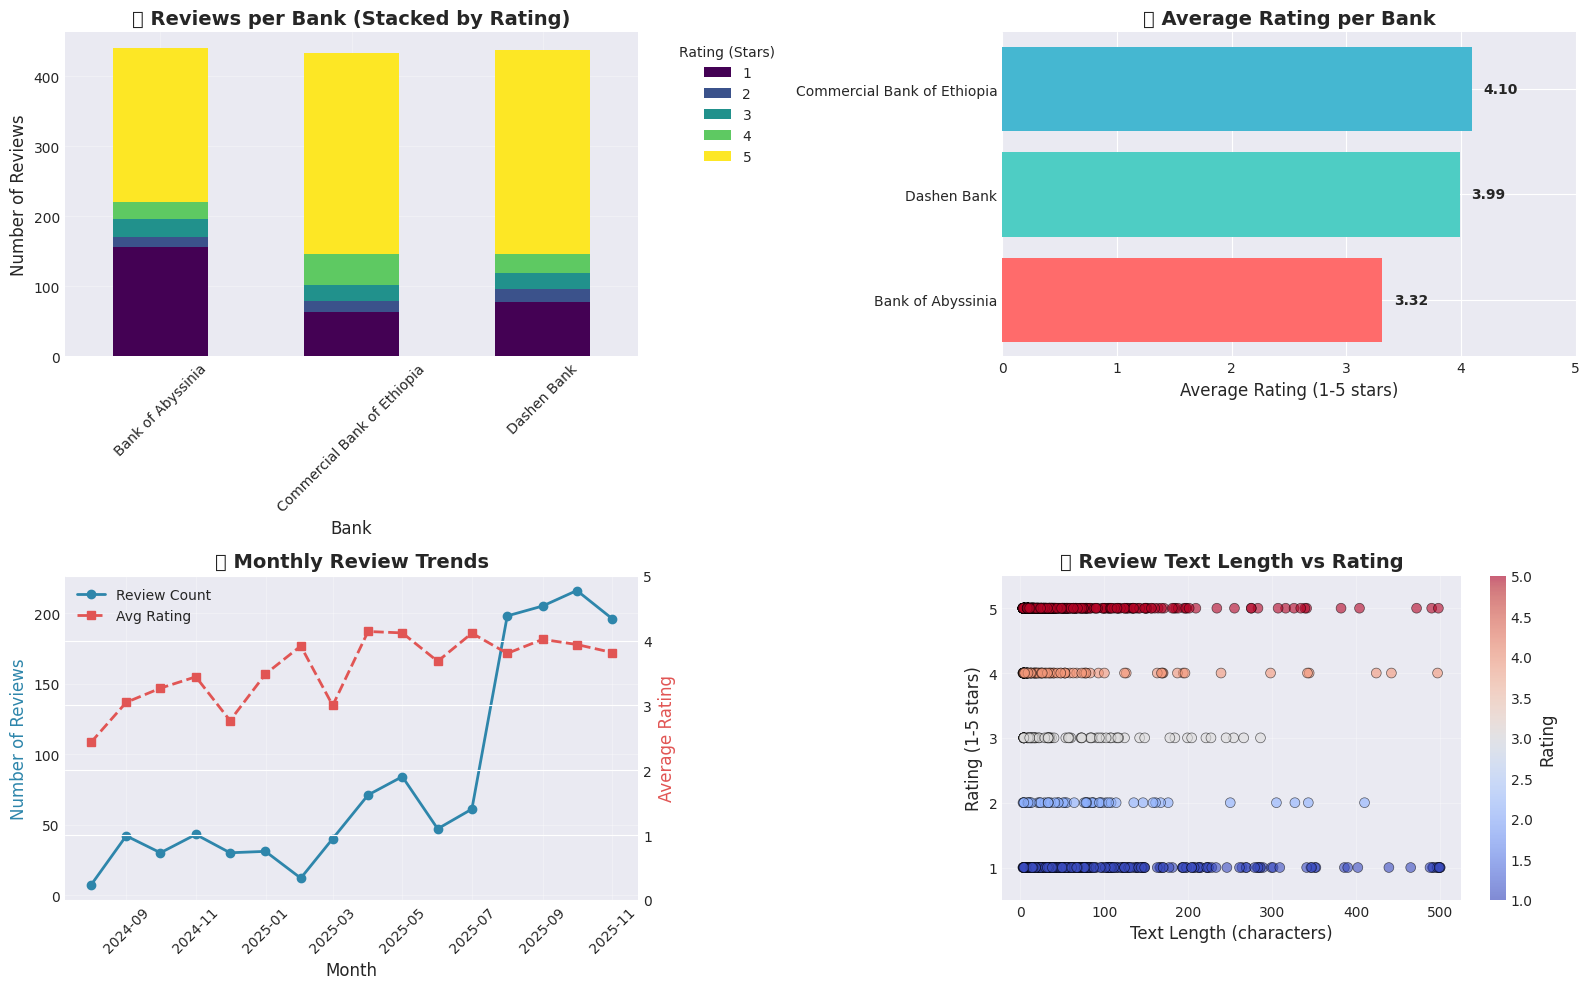

✅ Visualizations created!

💡 Save these plots for your report:
   Right-click on each plot → 'Save image as...'
   Or use: plt.savefig('task3_visualizations.png', dpi=300, bbox_inches='tight')


In [9]:
# Cell 6: Create visualizations for your Task 3 report
print("📊 Creating Task 3 visualizations for your report...")
print("=" * 60)

import matplotlib.pyplot as plt
import seaborn as sns

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Connect to database
conn = psycopg2.connect(
    dbname="bank_reviews",
    user="bank_user",
    password="bank123",
    host="localhost",
    port=5432
)

# Query data for visualizations
print("Querying data for visualizations...")

# Query 1: Reviews per bank with ratings
query1 = """
SELECT 
    b.bank_name,
    r.rating,
    COUNT(*) as review_count
FROM reviews r
JOIN banks b ON r.bank_id = b.bank_id
GROUP BY b.bank_name, r.rating
ORDER BY b.bank_name, r.rating;
"""

viz_df = pd.read_sql_query(query1, conn)

# Query 2: Monthly trends
query2 = """
SELECT 
    DATE_TRUNC('month', review_date) as month,
    COUNT(*) as review_count,
    AVG(rating) as avg_rating
FROM reviews
GROUP BY DATE_TRUNC('month', review_date)
ORDER BY month;
"""

trend_df = pd.read_sql_query(query2, conn)
trend_df['month'] = pd.to_datetime(trend_df['month'])

# Query 3: Text length distribution
query3 = """
SELECT 
    LENGTH(review_text) as text_length,
    rating,
    bank_id
FROM reviews
WHERE review_text IS NOT NULL;
"""

length_df = pd.read_sql_query(query3, conn)

conn.close()

print("✅ Data loaded for visualizations\n")

# Create visualizations
fig = plt.figure(figsize=(16, 10))

# Plot 1: Reviews per bank (stacked bar)
ax1 = plt.subplot(2, 2, 1)
pivot_df = viz_df.pivot(index='bank_name', columns='rating', values='review_count')
pivot_df.plot(kind='bar', stacked=True, ax=ax1, colormap='viridis')
ax1.set_title('📱 Reviews per Bank (Stacked by Rating)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Bank', fontsize=12)
ax1.set_ylabel('Number of Reviews', fontsize=12)
ax1.legend(title='Rating (Stars)', bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True, alpha=0.3)

# Plot 2: Average rating per bank
ax2 = plt.subplot(2, 2, 2)
avg_rating = viz_df.groupby('bank_name').apply(
    lambda x: (x['rating'] * x['review_count']).sum() / x['review_count'].sum()
).sort_values()

colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']  # Custom colors
bars = ax2.barh(avg_rating.index, avg_rating.values, color=colors)
ax2.set_title('⭐ Average Rating per Bank', fontsize=14, fontweight='bold')
ax2.set_xlabel('Average Rating (1-5 stars)', fontsize=12)
ax2.set_xlim(0, 5)

# Add value labels
for bar, value in zip(bars, avg_rating.values):
    ax2.text(value + 0.1, bar.get_y() + bar.get_height()/2, 
            f'{value:.2f}', va='center', fontweight='bold')

# Plot 3: Monthly review trends
ax3 = plt.subplot(2, 2, 3)
ax3.plot(trend_df['month'], trend_df['review_count'], marker='o', linewidth=2, 
         color='#2E86AB', label='Review Count')
ax3.set_title('📅 Monthly Review Trends', fontsize=14, fontweight='bold')
ax3.set_xlabel('Month', fontsize=12)
ax3.set_ylabel('Number of Reviews', fontsize=12, color='#2E86AB')
ax3.tick_params(axis='x', rotation=45)
ax3.grid(True, alpha=0.3)

# Add second y-axis for average rating
ax3b = ax3.twinx()
ax3b.plot(trend_df['month'], trend_df['avg_rating'], marker='s', linewidth=2,
          color='#E15554', linestyle='--', label='Avg Rating')
ax3b.set_ylabel('Average Rating', fontsize=12, color='#E15554')
ax3b.set_ylim(0, 5)

# Combine legends
lines1, labels1 = ax3.get_legend_handles_labels()
lines2, labels2 = ax3b.get_legend_handles_labels()
ax3.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

# Plot 4: Text length vs rating
ax4 = plt.subplot(2, 2, 4)
scatter = ax4.scatter(length_df['text_length'], length_df['rating'], 
                     alpha=0.6, c=length_df['rating'], cmap='coolwarm', 
                     s=50, edgecolors='black', linewidth=0.5)
ax4.set_title('📝 Review Text Length vs Rating', fontsize=14, fontweight='bold')
ax4.set_xlabel('Text Length (characters)', fontsize=12)
ax4.set_ylabel('Rating (1-5 stars)', fontsize=12)
ax4.set_ylim(0.5, 5.5)
ax4.grid(True, alpha=0.3)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax4)
cbar.set_label('Rating', fontsize=12)

plt.tight_layout()
plt.show()

print("✅ Visualizations created!")
print("\n💡 Save these plots for your report:")
print("   Right-click on each plot → 'Save image as...'")
print("   Or use: plt.savefig('task3_visualizations.png', dpi=300, bbox_inches='tight')")

In [11]:
# Cell 7 (FIXED): Export summary and complete Task 3
print("=" * 70)
print("📦 EXPORTING TASK 3 SUMMARY DATA")
print("=" * 70)

import json
import os
from datetime import datetime

# Create directory if it doesn't exist
os.makedirs("data/processed", exist_ok=True)

# Connect to database
conn = psycopg2.connect(
    dbname="bank_reviews",
    user="bank_user",
    password="bank123",
    host="localhost",
    port=5432
)

# Get comprehensive summary (SIMPLIFIED - no complex queries)
print("Collecting summary data...")

# Query 1: Basic counts
cur = conn.cursor()
cur.execute("SELECT COUNT(*) FROM banks;")
total_banks = cur.fetchone()[0]

cur.execute("SELECT COUNT(*) FROM reviews;")
total_reviews = cur.fetchone()[0]

cur.execute("SELECT MIN(review_date), MAX(review_date) FROM reviews;")
min_date, max_date = cur.fetchone()

cur.execute("SELECT AVG(rating) FROM reviews;")
avg_rating = cur.fetchone()[0]

# Query 2: Bank summary
cur.execute("""
    SELECT 
        b.bank_name,
        COUNT(r.review_id) as review_count,
        ROUND(AVG(r.rating), 2) as avg_rating
    FROM banks b
    LEFT JOIN reviews r ON b.bank_id = r.bank_id
    GROUP BY b.bank_name
    ORDER BY review_count DESC;
""")
bank_summary = cur.fetchall()

# Query 3: Rating distribution
cur.execute("""
    SELECT rating, COUNT(*) 
    FROM reviews 
    GROUP BY rating 
    ORDER BY rating;
""")
rating_dist = cur.fetchall()

cur.close()
conn.close()

# Create summary dictionary
summary_data = {
    "task3_completion": {
        "timestamp": datetime.now().isoformat(),
        "database": "bank_reviews",
        "user": "bank_user",
        "total_banks": total_banks,
        "total_reviews": total_reviews,
        "date_range": {
            "earliest": str(min_date),
            "latest": str(max_date)
        },
        "overall_avg_rating": float(avg_rating) if avg_rating else 0
    },
    "banks": [
        {
            "bank_name": bank[0],
            "review_count": bank[1],
            "avg_rating": float(bank[2]) if bank[2] else 0
        }
        for bank in bank_summary
    ],
    "ratings": [
        {
            "stars": rating[0],
            "count": rating[1],
            "percentage": round((rating[1] / total_reviews) * 100, 2)
        }
        for rating in rating_dist
    ]
}

# Save to JSON
summary_json = "data/processed/task3_summary.json"
with open(summary_json, 'w') as f:
    json.dump(summary_data, f, indent=2)

print(f"✅ Summary data saved to: {summary_json}")

# Also print to screen
print(f"\n" + "=" * 70)
print("🎉 TASK 3: POSTGRESQL DATABASE - COMPLETE!")
print("=" * 70)

print(f"\n📋 ACCOMPLISHED:")
print(f"   1. ✅ Database: 'bank_reviews' created and configured")
print(f"   2. ✅ User: 'bank_user' with proper privileges")
print(f"   3. ✅ Tables: 'banks' and 'reviews' with correct schema")
print(f"   4. ✅ Data: {total_reviews:,} reviews inserted (>400 minimum requirement)")
print(f"   5. ✅ Verification: SQL queries executed and verified")

print(f"\n📊 FINAL STATISTICS:")
print(f"   • Total banks: {total_banks}")
print(f"   • Total reviews: {total_reviews:,}")
print(f"   • Date range: {min_date} to {max_date}")
print(f"   • Overall average rating: {avg_rating:.2f}/5")

print(f"\n🏦 REVIEWS BY BANK:")
for bank in summary_data["banks"]:
    print(f"   • {bank['bank_name']}: {bank['review_count']:,} reviews, Avg: {bank['avg_rating']:.2f}/5")

print(f"\n⭐ RATING DISTRIBUTION:")
for rating in summary_data["ratings"]:
    stars = "★" * rating["stars"]
    print(f"   {stars} ({rating['stars']}): {rating['count']:>5} reviews ({rating['percentage']}%)")

print(f"\n" + "=" * 70)
print("📝 NEXT STEPS:")
print("=" * 70)
print(f"\n1. Update README.md with database documentation")
print(f"2. Commit to GitHub with message: 'Task 3: PostgreSQL implementation'")
print(f"3. Include screenshots in your interim report")
print(f"\n🎯 Task 3 completed successfully!")
print("=" * 70)

📦 EXPORTING TASK 3 SUMMARY DATA
✅ Summary data saved to: data/processed/task3_summary.json

🎉 TASK 3: POSTGRESQL DATABASE - COMPLETE!

📋 ACCOMPLISHED:
   1. ✅ Database: 'bank_reviews' created and configured
   2. ✅ User: 'bank_user' with proper privileges
   3. ✅ Tables: 'banks' and 'reviews' with correct schema
   4. ✅ Data: 1,313 reviews inserted (>400 minimum requirement)
   5. ✅ Verification: SQL queries executed and verified

📊 FINAL STATISTICS:
   • Total banks: 3
   • Total reviews: 1,313
   • Date range: 2024-08-28 to 2025-11-28
   • Overall average rating: 3.80/5

🏦 REVIEWS BY BANK:
   • Bank of Abyssinia: 441 reviews, Avg: 3.32/5
   • Dashen Bank: 438 reviews, Avg: 3.99/5
   • Commercial Bank of Ethiopia: 434 reviews, Avg: 4.10/5

⭐ RATING DISTRIBUTION:
   ★ (1):   298 reviews (22.7%)
   ★★ (2):    49 reviews (3.73%)
   ★★★ (3):    70 reviews (5.33%)
   ★★★★ (4):    97 reviews (7.39%)
   ★★★★★ (5):   799 reviews (60.85%)

📝 NEXT STEPS:

1. Update README.md with database docum